In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics


In [2]:
spot_size = 100
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

In [3]:
adata_1=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.14.h5ad')
adata_1.var_names_make_unique(join="++")
adata_1.obs['annotation'] = adata_1.obs['ground_truth']
adata_1

AnnData object with n_obs × n_vars = 5926 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'annotation'
    uns: 'domain_colors'
    obsm: 'spatial'

In [4]:
adata_2=sc.read_h5ad('D:\ppppaper\data\MERFISH\MERFISH_0.19.h5ad')
adata_2.var_names_make_unique(join="++")
adata_2.obs['annotation'] = adata_2.obs['ground_truth']
adata_2

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'annotation'
    uns: 'domain_colors'
    obsm: 'spatial'

In [5]:
x1_coords=adata_1.obsm['spatial'][:,0]
y1_coords=adata_1.obsm['spatial'][:,1]
x2_coords=adata_2.obsm['spatial'][:,0]
y2_coords=adata_2.obsm['spatial'][:,1]
locations_1 = np.array([x1_coords, y1_coords])
locations_2 = np.array([x2_coords, y2_coords])

locations_1_tensor = torch.tensor(locations_1)
locations_2_tensor = torch.tensor(locations_2)
locations_1_tensor = locations_1_tensor.transpose(0, 1)
locations_1_tensor = locations_1_tensor.to(dtype=torch.float32)
locations_2_tensor = locations_2_tensor.transpose(0, 1)
locations_2_tensor = locations_2_tensor.to(dtype=torch.float32)
location = [locations_1_tensor, locations_2_tensor]

In [6]:
Cal_Spatial_Net(adata_1, k_cutoff=15, model='KNN')
Cal_Spatial_Net(adata_2, k_cutoff=15, model='KNN')

Calculating spatial neighbor graph ...
The graph contains 97466 edges, 5926 cells.
16.44718191022612 neighbors per cell on average.
Calculating spatial neighbor graph ...
The graph contains 96091 edges, 5803 cells.
16.55884887127348 neighbors per cell on average.


In [7]:
edges, features = load_anndatas([adata_1, adata_2], feature='DPCA')

Use DPCA feature to format graph


d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actu

In [13]:
embd0_0, embd0_1, embd1_0, embd1_1, embd0, embd1, time = run_SLAT_AGF_contrast(features, edges, location, limit_loss=0.0001)

GPU is not available
Running
---------- epochs: 1 ----------
---- Ran row_normalize in 0.02 s ----

---- Ran row_normalize in 0.04 s ----

---------- epochs: 2 ----------
---- Ran row_normalize in 0.04 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 3 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 4 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 5 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.03 s ----

---------- epochs: 6 ----------
---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.04 s ----

---- Ran row_normalize in 0.03 s ----

---- Ran row_normalize in 0.04 s ----

---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
---------- Combined epochs: 0 ----------


In [14]:
adata_1.obsm['stLVG'] = embd0.detach().cpu().numpy()
adata_2.obsm['stLVG'] = embd1.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'stLVG')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


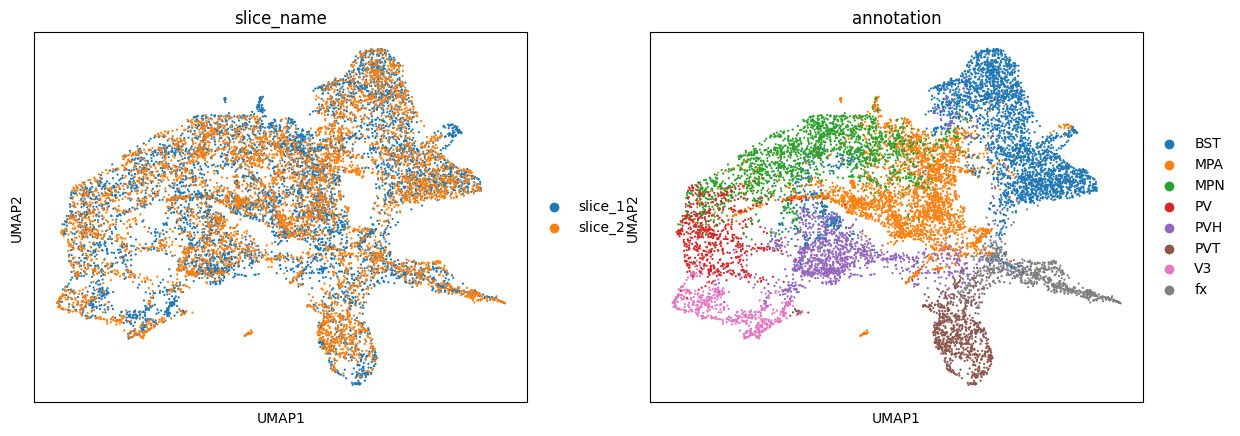

In [15]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [13]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='scSLAT_bks', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.3292502181266055, 'iLISI': 1.7072282740979376}


In [16]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best, index, distance = spatial_match([embd0, embd1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best < true_labels_1.size
valid_best = best[valid_indices]
valid_indices = np.arange(len(best))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.6174444296574115, NMI: 0.6782572303068448


In [17]:
adata1_df = pd.DataFrame({'index': range(embd0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata2_df = pd.DataFrame({'index': range(embd1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching = np.array([range(index.shape[0]), best])
best_match = distance[:,0]

In [18]:
adata2_df['target_celltype'] = adata1_df.iloc[matching[1,:],:]['celltype'].to_list()
matching_table = adata2_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

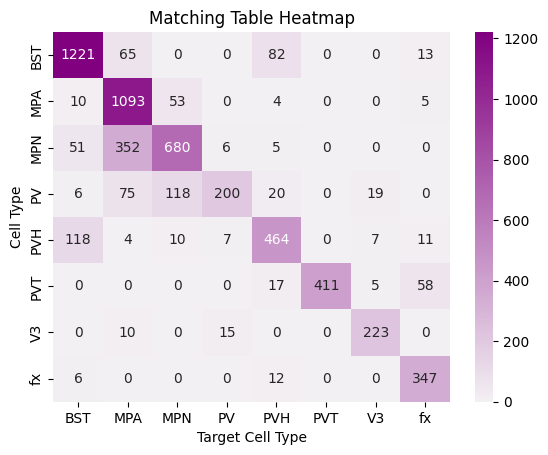

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

custom_cmap = sns.color_palette("light:purple", as_cmap=True)

sns.heatmap(matching_table, annot = True, fmt = "d", cmap = custom_cmap)
plt.title('Matching Table Heatmap')
plt.xlabel('Target Cell Type')
plt.ylabel('Cell Type')
plt.show()

In [19]:
correct_matches = 0
total_matches = 0

for i, row in matching_table.iterrows():
    if i in matching_table.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(4669, 5803, 0.804583835946924)

In [19]:
first_indices = matching[0]
second_indices = matching[1]
second_array_labels = adata1_df.iloc[second_indices]['celltype'].values

max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels

adata_2.obs['transferred_labels'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

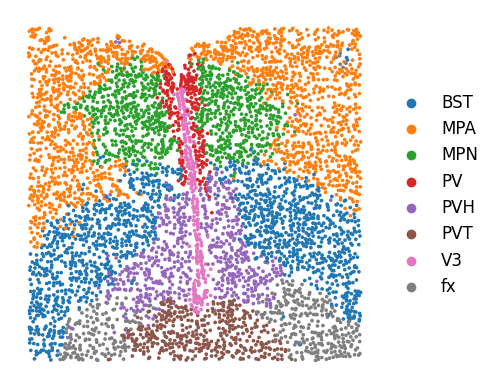

In [20]:
spot_size = 20
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

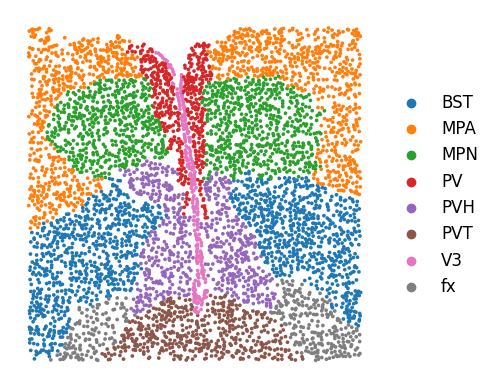

In [21]:
spot_size = 20
sc.pl.spatial(adata_2, img_key=None, color=['annotation'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [22]:
embd2, embd3, time = run_SLAT(features, edges)

GPU is not available
Running
---------- epochs: 1 ----------
---------- epochs: 2 ----------
---------- epochs: 3 ----------
---------- epochs: 4 ----------
---------- epochs: 5 ----------
---------- epochs: 6 ----------
Training model time: 52.25


In [23]:
adata_1.obsm['scSLAT'] = embd2.detach().cpu().numpy()
adata_2.obsm['scSLAT'] = embd3.detach().cpu().numpy()
adata_com_2 = sc.concat([adata_1,adata_2], label= 'slice_name', keys= ['slice_1','slice_2'])

sc.pp.neighbors(adata_com_2, use_rep= 'scSLAT')
sc.tl.umap(adata_com_2)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


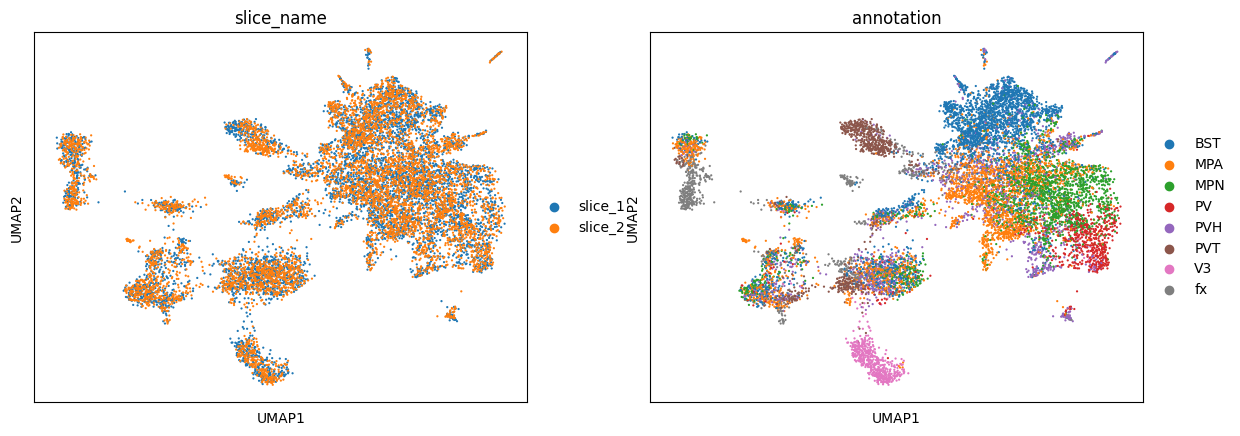

In [24]:
sc.pl.umap(adata_com_2, color= ['slice_name', 'annotation'])

In [25]:
lisi_scores_2 = compute_lisi_for_adata(adata_com_2, obsm_key='scSLAT', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores_2)

LISI Scores:
 {'cLISI': 2.004864002413824, 'iLISI': 1.8255793062755608}


In [26]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best_2, index_2, distance_2 = spatial_match([embd2, embd3], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best_2 < true_labels_1.size
valid_best = best_2[valid_indices]
valid_indices = np.arange(len(best_2))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.5346487179525845, NMI: 0.6013464676935049


In [27]:
adata3_df = pd.DataFrame({'index': range(embd2.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata4_df = pd.DataFrame({'index': range(embd3.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_2 = np.array([range(index_2.shape[0]), best_2])
best_match_2 = distance_2[:,0]

In [28]:
adata4_df['target_celltype'] = adata3_df.iloc[matching_2[1,:],:]['celltype'].to_list()
matching_table_2 = adata4_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [29]:
correct_matches = 0
total_matches = 0

for i, row in matching_table_2.iterrows():
    if i in matching_table_2.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(4391, 5803, 0.7566775805617784)

In [30]:
first_indices = matching_2[0]
second_indices = matching_2[1]
second_array_labels = adata3_df.iloc[second_indices]['celltype'].values

max_index = first_indices.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices] = second_array_labels

adata_2.obs['transferred_labels_SLAT'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

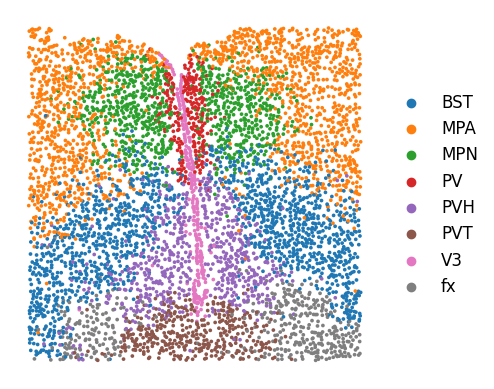

In [31]:
spot_size = 20
adata_2.obs['transferred_labels_SLAT'] = adata_2.obs['transferred_labels_SLAT'].astype(str)
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels_SLAT'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [32]:
adata_1.obsm['m0'] = embd0_0.detach().cpu().numpy()
adata_2.obsm['m0'] = embd1_0.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'm0')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


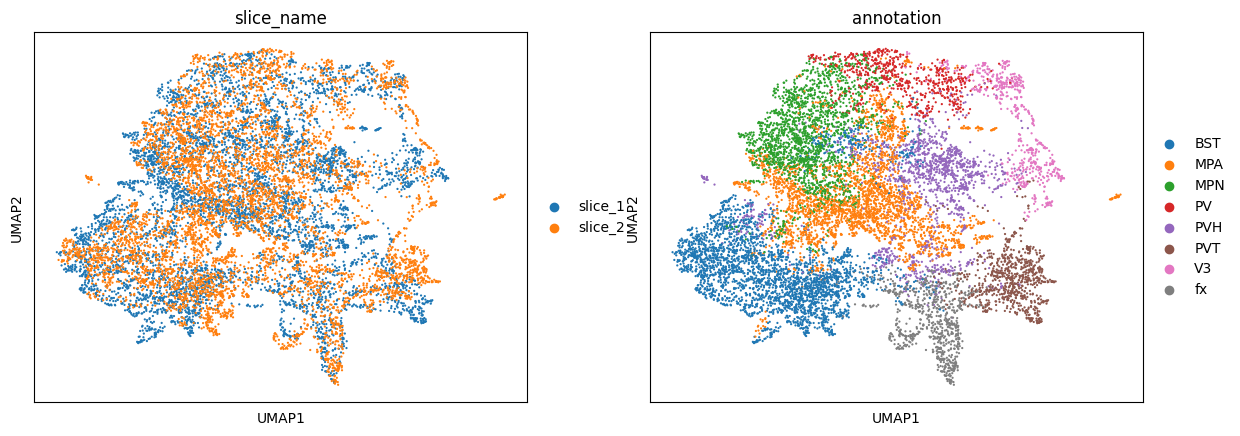

In [33]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [34]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='m0', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.3217254881877343, 'iLISI': 1.4421107039428862}


In [35]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best_3, index_3, distance_3 = spatial_match([embd0_0, embd1_0], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best_3 < true_labels_1.size
valid_best = best_3[valid_indices]
valid_indices = np.arange(len(best_3))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.5910861853882334, NMI: 0.6331653322553623


In [36]:
adata5_df = pd.DataFrame({'index': range(embd0_0.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata6_df = pd.DataFrame({'index': range(embd1_0.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_3 = np.array([range(index_3.shape[0]), best_3])
best_match_3 = distance_3[:,0]

In [37]:
adata6_df['target_celltype'] = adata5_df.iloc[matching_3[1,:],:]['celltype'].to_list()
matching_table_3 = adata6_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [38]:
correct_matches = 0
total_matches = 0

for i, row in matching_table_3.iterrows():
    if i in matching_table_3.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(4563, 5803, 0.7863174220230915)

In [39]:
adata_1.obsm['m1'] = embd0_1.detach().cpu().numpy()
adata_2.obsm['m1'] = embd1_1.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'm1')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


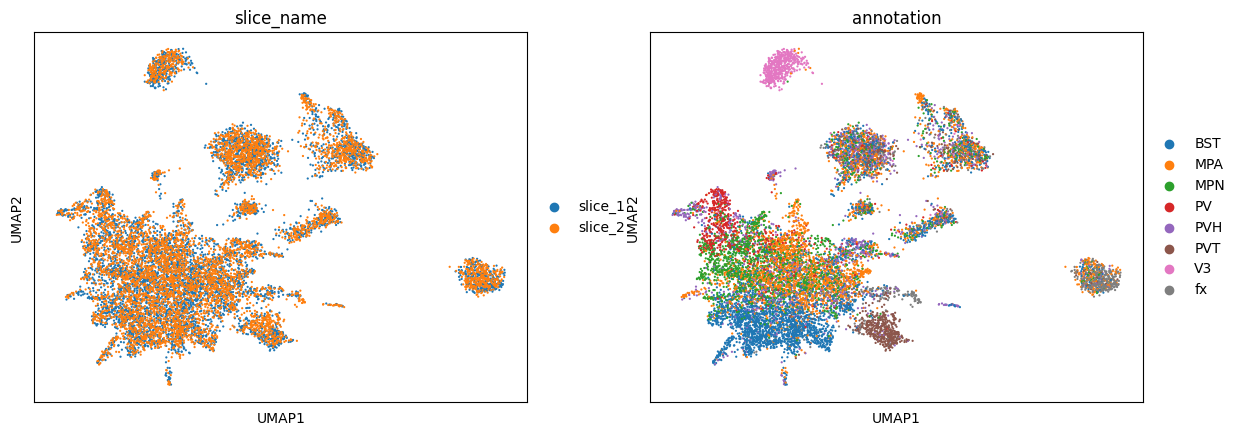

In [40]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [41]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='m1', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 2.4750305324134882, 'iLISI': 1.8435619385969533}


In [42]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best_4, index_4, distance_4 = spatial_match([embd0_1, embd1_1], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best_4 < true_labels_1.size
valid_best = best_4[valid_indices]
valid_indices = np.arange(len(best_4))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.45936446223913824, NMI: 0.5321062600899966


In [43]:
adata7_df = pd.DataFrame({'index': range(embd0_1.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata8_df = pd.DataFrame({'index': range(embd1_1.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_4 = np.array([range(index_4.shape[0]), best_4])
best_match_4 = distance_4[:,0]

In [44]:
adata8_df['target_celltype'] = adata7_df.iloc[matching_4[1,:],:]['celltype'].to_list()
matching_table_4 = adata8_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [45]:
correct_matches = 0
total_matches = 0

for i, row in matching_table_4.iterrows():
    if i in matching_table_4.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(4082, 5803, 0.70342926072721)

In [46]:
combine_1 = torch.cat([embd0_0, embd0_1], dim=1)
combine_2 = torch.cat([embd1_0, embd1_1], dim=1)

In [47]:
adata_1.obsm['combine'] = combine_1.detach().cpu().numpy()
adata_2.obsm['combine'] = combine_2.detach().cpu().numpy()

adata_com = sc.concat([adata_1, adata_2], label='slice_name', keys=['slice_1', 'slice_2'])

sc.pp.neighbors(adata_com, use_rep= 'combine')
sc.tl.umap(adata_com)

d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


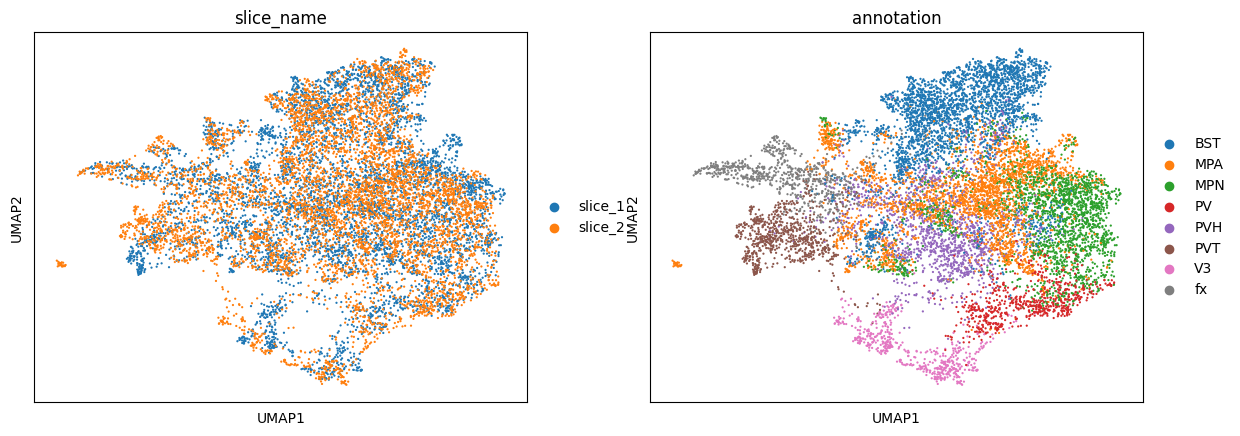

In [48]:
sc.pl.umap(adata_com, color= ['slice_name', 'annotation'])

In [49]:
lisi_scores = compute_lisi_for_adata(adata_com, obsm_key='combine', obs_key_list=['annotation', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.4809842254489995, 'iLISI': 1.626102085470416}


In [50]:
true_labels_1 = adata_1.obs['annotation'].to_numpy()
true_labels_2 = adata_2.obs['annotation'].to_numpy()

best_5, index_5, distance_5 = spatial_match([combine_1, combine_2], adatas=[adata_1, adata_2], reorder=False)
valid_indices = best_5 < true_labels_1.size
valid_best = best_5[valid_indices]
valid_indices = np.arange(len(best_5))[valid_indices] 

aligned_true_labels_1 = true_labels_1[valid_best]
matched_labels_3 = true_labels_2[valid_indices]

# 计算 ARI 和 NMI
ari = adjusted_rand_score(aligned_true_labels_1, matched_labels_3)
nmi = normalized_mutual_info_score(aligned_true_labels_1, matched_labels_3)

print(f'ARI: {ari}, NMI: {nmi}')

ARI: 0.5947847362886635, NMI: 0.6463813564391814


In [51]:
adata9_df = pd.DataFrame({'index': range(combine_1.shape[0]),
                        'x': adata_1.obsm['spatial'][:,0],
                        'y': adata_1.obsm['spatial'][:,1],
                        'celltype': adata_1.obs['annotation']})
adata10_df = pd.DataFrame({'index': range(combine_2.shape[0]),
                        'x': adata_2.obsm['spatial'][:,0],
                        'y': adata_2.obsm['spatial'][:,1],
                        'celltype': adata_2.obs['annotation']})

matching_5 = np.array([range(index_5.shape[0]), best_5])
best_match_5 = distance_5[:,0]

In [52]:
adata10_df['target_celltype'] = adata9_df.iloc[matching_5[1,:],:]['celltype'].to_list()
matching_table_5 = adata10_df.groupby(['celltype','target_celltype']).size().unstack(fill_value=0)

In [53]:
correct_matches = 0
total_matches = 0

for i, row in matching_table_5.iterrows():
    if i in matching_table_5.columns and row[i] > 0:
        correct_matches += row[i]
    total_matches += row.sum()


accuracy = correct_matches / total_matches if total_matches > 0 else 0
correct_matches,total_matches,accuracy

(4598, 5803, 0.7923487851111494)

In [54]:
first_indices_5 = matching_5[0]
second_indices_5 = matching_5[1]
second_array_labels_5 = adata1_df.iloc[second_indices]['celltype'].values

max_index = first_indices_5.max()
new_labels = np.empty(max_index + 1, dtype=object)

# transfer
new_labels[first_indices_5] = second_array_labels_5
adata_2.obs['transferred_labels_combine'] = new_labels

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

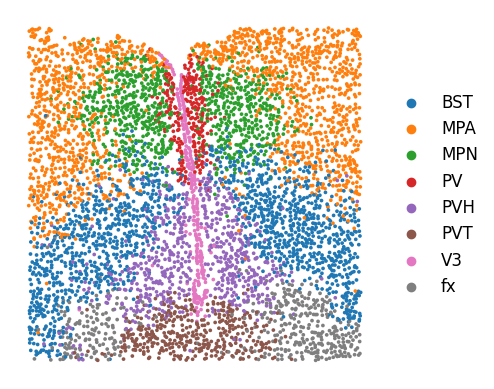

In [55]:
spot_size = 20
sc.pl.spatial(adata_2, img_key=None, color=['transferred_labels_combine'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [ ]:
# adata_1.write('D:\ppppaper\data\Result\MERFISH_0.14.h5ad')

In [ ]:
# adata_2.write('D:\ppppaper\data\Result\MERFISH_0.19.h5ad')

In [56]:
# adata_1=sc.read_h5ad('D:\ppppaper\data\Result\MERFISH_0.14.h5ad')
# adata_1

In [59]:
# adata_2=sc.read_h5ad('D:\ppppaper\data\Result\MERFISH_0.19.h5ad')
adata_2

AnnData object with n_obs × n_vars = 5803 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'ground_truth', 'annotation', 'transferred_labels', 'transferred_labels_SLAT', 'transferred_labels_combine'
    uns: 'domain_colors', 'Spatial_Net', 'transferred_labels_colors', 'annotation_colors', 'transferred_labels_SLAT_colors', 'transferred_labels_combine_colors'
    obsm: 'spatial', 'scSLAT_bks', 'scSLAT', 'm0', 'm1', 'combine'

In [58]:
# spot_size = 50
# sc.pl.spatial(adata_2, img_key=None, color=['annotation'], title=[''],
#                 legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
#                 spot_size=spot_size)